# Trying stuff with gpt models
    

In [58]:
%load_ext autoreload
%autoreload 2

from earplugenv import EarplugEnv

from utils.env import plot_env

import termtables as tt 
import numpy as np 

from gpt import ChatApp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# 0 is right, 1 is down, 2 is left, 3 is up
DIR_TO_ARROW = {0: "\u2192", 1: "\u2193", 2: "\u2190", 3: "\u2191"}

ACTION_TO_WORDS = {0: "Turn left", 1: "Turn right", 2: "Move forward"}

In [47]:
def cell_type_to_char(cell_type):
    if cell_type == "floor":
        return "F"
    elif cell_type == "wall":
        return "W"
    elif cell_type == "goal":
        return "G"
    else:
        raise ValueError("unknown cell type")
    
def env_to_str(env):
    grid_list = []

    for cell in env.grid.grid:
        try:
            grid_list.append(cell.type)
        except AttributeError:
            grid_list.append("floor")

    # calculate the side length of the square array
    n = int(np.sqrt(len(grid_list)))

    grid_arr = np.array(list(map(cell_type_to_char, grid_list))).reshape(n, n)
    
    # place agent, need to switch coords from minigrid to numpy notation
    grid_arr[env.agent_pos[1], env.agent_pos[0]] = DIR_TO_ARROW[env.agent_dir]

    grid_str = tt.to_string(
        grid_arr,
        style=tt.styles.ascii_thin,
    )

    return grid_str

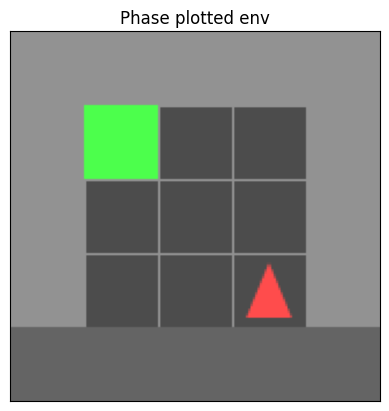

In [48]:
env = EarplugEnv(phase=3, size=5, render_mode="rgb_array")
env.reset()
plot_env(env)

In [51]:
grid = env_to_str(env)
print(grid)

+---+---+---+---+---+
| W | W | W | W | W |
+---+---+---+---+---+
| W | G | F | F | W |
+---+---+---+---+---+
| W | F | F | F | W |
+---+---+---+---+---+
| W | F | F | ↑ | W |
+---+---+---+---+---+
| W | W | W | W | W |
+---+---+---+---+---+


In [64]:
system_text = """ 
        You are an agent that acts in a grid world.

        Description: You want to get to the goal with as few steps as possible.

        The W means Wall, which you can't walk to.
        The F means Floor, which you can walk over. 
        The arrow indicates your position and your direction. 
        The G means Goal, which is where you have to go. 

        Actions: There are three actions available
            0 is turn left
            1 is turn right
            2 is move forward

        I will give you the grid and the reward.
        You respond with an action.
        """

In [65]:
gpt = ChatApp(system_text="horse")

max_steps = 10
i = 0 
actions = []
reward = 0
terminated, truncated = False, False
env.reset()

for i in range(max_steps):
    print(f"\n\nStep: {i}")
    grid_str = env_to_str(env)
    
    #NOTE: maybe include reward
    prompt = f"""
    This is the grid: 
    {grid_str}

    What is your action?
    Only specify one number of {{0, 1, 2}} as your output. 
    Do not say anything else. 
    Think carefully about your action.
    Make sure it is the best action.
    """

    action = int(gpt.chat(prompt))
    actions.append(action)

    print(f"Action: {ACTION_TO_WORDS[action]} \n {grid_str}")
    
    _, reward, terminated, _, _ = env.step(action)

    if terminated:
        print("\nGoal reached! Woohoo!")
        break

actions



Step: 0
Action: Turn right 
 +---+---+---+---+---+
| W | W | W | W | W |
+---+---+---+---+---+
| W | F | F | F | W |
+---+---+---+---+---+
| W | F | F | → | W |
+---+---+---+---+---+
| W | F | F | G | W |
+---+---+---+---+---+
| W | W | W | W | W |
+---+---+---+---+---+


Step: 1
Action: Move forward 
 +---+---+---+---+---+
| W | W | W | W | W |
+---+---+---+---+---+
| W | F | F | F | W |
+---+---+---+---+---+
| W | F | F | ↓ | W |
+---+---+---+---+---+
| W | F | F | G | W |
+---+---+---+---+---+
| W | W | W | W | W |
+---+---+---+---+---+
Goal reached! Woohoo!


[1, 2]

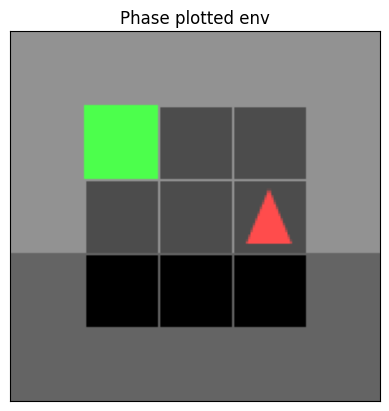

3 (3, 2)


In [31]:
env.reset()
plot_env(env)
print(env.agent_dir, env.agent_pos)